In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import binom_test 
import os

import seaborn as sns
sns.set(font_scale= 1.5)
sns.set_style('whitegrid') 

import sys
sys.path.append('/work-zfs/abattle4/heyuan/old_work_files/yuan/tools/python_lib/lib/python2.7/site-packages')

from matplotlib_venn import venn3, venn2

from statsmodels.stats.multitest import multipletests
sns.set(font_scale= 1.5)
sns.set_style('whitegrid')

from scipy.stats import ranksums


In [54]:
def read_in_WGS_GT(sample):
    WGS_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/Genotype'

    chromosome = 22
    WGS_fn = '%s/1k_genome_chr%d.genotypes.tsv' % (WGS_dir, chromosome)
    WGS_result = pd.read_csv(WGS_fn, comment = '$', sep='\t', nrows = 10)
    try:
        col_to_read = list(WGS_result.columns).index(sample)
    except:
        print('%s does not have genotype data' % sample)
        return 
    
    WGS_result = pd.DataFrame()

    for chromosome in range(1,23):
        WGS_fn = '%s/1k_genome_chr%d.genotypes.tsv' % (WGS_dir, chromosome)
        token = pd.read_csv(WGS_fn, 
                            comment = '$', 
                            sep='\t', 
                            usecols=[0,1,2,col_to_read])
        WGS_result = WGS_result.append(token)    
        
    WGS_result = WGS_result.drop_duplicates()
        
    return WGS_result

In [68]:
def obtain_intersection_df(sample, minDP, WGS_result, restrict_to_SNP = True):
    
    WGS_result = WGS_result.copy()
    
    SNP_calling_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/ATAC_seq/alignment_bowtie'
        
    SNP_called_fn = '%s/%s-RG-dedup-hapcal.filtered.genotype.minDP%d.txt' % (SNP_calling_dir, sample, minDP)
    SNP_called = pd.read_csv(SNP_called_fn, comment="$", sep='\t', nrows = 10)
    try:
        col_to_read = np.where([sample in x for x in SNP_called.columns])[0][0]
    except:
        print('%s does not called genotpye' % sample)
        return
    
    SNP_called = pd.read_csv(SNP_called_fn, comment="$", sep='\t', usecols=[0, 1, 2, col_to_read])
    SNP_called.columns = list(SNP_called.columns[:3]) + ['%s_called' % sample]
    SNP_called['#CHROM'] = [int(x.replace('chr','')) for x in SNP_called['#CHROM']]
    
    # restrict to SNP
    if restrict_to_SNP:
        WGS_result = WGS_result.iloc[np.where([len(x) == 1 for x in WGS_result['REF']])[0]]
        
        WGS_result = WGS_result.iloc[np.where([len(x.split('/')[0]) == 1 for x in WGS_result[sample]])[0]]
        WGS_result = WGS_result.iloc[np.where([len(x.split('/')[1]) == 1 for x in WGS_result[sample]])[0]]
        
        SNP_called = SNP_called.iloc[np.where([len(x.split('/')[1]) == 1 for x in SNP_called['%s_called' % sample]])[0]]
        SNP_called = SNP_called.iloc[np.where([len(x.split('/')[1]) == 1 for x in SNP_called['%s_called' % sample]])[0]]
    
    # variants with some read
    intersection_SNPs = WGS_result.merge(SNP_called, on=['#CHROM', 'POS'])
    
    # match for the HT order
    intersection_SNPs['%s_makeup' % sample] = ['/'.join(x.split('/')[::-1]) for x in intersection_SNPs[sample]]
    
    HT = np.where(intersection_SNPs[sample] != intersection_SNPs['%s_makeup' % sample])[0]
    match_idx = np.where(intersection_SNPs['%s_called' % sample] == intersection_SNPs['%s_makeup' % sample])[0]
    need_to_flip = np.intersect1d(HT, match_idx)
    intersection_SNPs.loc[need_to_flip,sample] = intersection_SNPs.loc[need_to_flip,'%s_makeup' % sample]

    true_hits = np.sum(intersection_SNPs[sample] == intersection_SNPs['%s_called' % sample])

    print('For %s:' % sample)
    print("In total, WGS called %d SNVs" % len(WGS_result))
    print("Variant caller called %d SNVs" % len(SNP_called))
    
    print("Variant called called %d (%.3f) SNVs found in WGS" % (len(intersection_SNPs), 
                                                                 len(intersection_SNPs)/len(SNP_called)))

    print("   %d (%.3f) are correct" % (true_hits, true_hits / len(SNP_called)))
    
    
    return intersection_SNPs

In [25]:
def transform_genotype_number(intersection_df, base_on_col = sample):
    intersection_df['Alt1'] = [x.split('/')[0] for x in intersection_df[base_on_col]]
    intersection_df['Alt2'] = [x.split('/')[1] for x in intersection_df[base_on_col]]
    intersection_df['MT']= (intersection_df['Alt1'] != intersection_df['REF_x']) & (intersection_df['Alt2'] != intersection_df['REF_x'])
    intersection_df['HT'] = intersection_df['Alt1'] != intersection_df['Alt2']

    # Assign Genotype number
    genotype_arr = np.zeros(len(intersection_df))

    # Heterozygous - AB
    genotype_arr[np.where(intersection_df['HT'])[0]] = 1

    # Homogenous wildtype
    genotype_arr[np.where((~intersection_df['HT']) & (~intersection_df['MT']))[0]] = 0
    
    # Homogenous mutation
    genotype_arr[np.where((~intersection_df['HT']) & (intersection_df['MT']))[0]] = 2
    
    return genotype_arr

In [26]:
def readin_INFO(sample):

    sample_info = pd.read_csv('%s/%s-RG-dedup-hapcal.filtered.variants.recode.INFO.txt' % (variant_calling_dir, sample),sep='\t', header = None)
    sample_info.columns=['#CHROM', 'POS', 'DP', 'PL']
    sample_info['#CHROM'] = [int(x.replace('chr', '')) for x in sample_info['#CHROM']]

    return sample_info


In [97]:
minDP = 10

sampleList = ['HG00096','HG00105','HG00106','HG00108','HG00109','HG00114','HG00117','HG00118','HG00120']
for sample in sampleList:
    print(sample)
    
    # WGS genotype
    WGS_df = read_in_WGS_GT(sample)

    # variant calling information
    variant_calling_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/ATAC_seq/alignment_bowtie'
    info_df = readin_INFO(sample)
    info_df_unamb = info_df[['0,0' not in x for x in info_df['PL']]]
    
    sample_df = obtain_intersection_df(sample, minDP = minDP, WGS_result=WGS_df)
    sample_df = sample_df.merge(info_df_unamb, on = ['#CHROM', 'POS'])

    true_genotype = transform_genotype_number(sample_df, base_on_col=sample)
    called_genotype = transform_genotype_number(sample_df, base_on_col='%s_called' % sample)

    save_df = sample_df[['#CHROM', 'POS', 'DP', 'PL']]
    save_df = save_df.copy()
    save_df['True_GT'] = true_genotype
    save_df['Called_GT'] = called_genotype

    save_df = save_df[['#CHROM', 'POS', 'Called_GT', 'True_GT', 'DP', 'PL']]
    save_df['Sample'] = sample
    save_df.to_csv('Genotypes/%s_minDP%d.bed' % (sample, minDP), sep='\t', index = False)
    
    

HG00096
For HG00096:
In total, WGS called 5977376 SNVs
Variant caller called 113217 SNVs
Variant called called 107810 (0.952) SNVs found in WGS
   105394 (0.931) are correct
HG00105
For HG00105:
In total, WGS called 5977285 SNVs
Variant caller called 97575 SNVs
Variant called called 92886 (0.952) SNVs found in WGS
   90676 (0.929) are correct
HG00106
For HG00106:
In total, WGS called 5977220 SNVs
Variant caller called 114542 SNVs
Variant called called 109012 (0.952) SNVs found in WGS
   106667 (0.931) are correct
HG00108
For HG00108:
In total, WGS called 5978305 SNVs
Variant caller called 54474 SNVs
Variant called called 51853 (0.952) SNVs found in WGS
   50771 (0.932) are correct
HG00109
For HG00109:
In total, WGS called 5976951 SNVs
Variant caller called 98886 SNVs
Variant called called 94021 (0.951) SNVs found in WGS
   91964 (0.930) are correct
HG00114
For HG00114:
In total, WGS called 5978720 SNVs
Variant caller called 44071 SNVs
Variant called called 41981 (0.953) SNVs found in W

In [99]:
all_called_sites = pd.read_csv('Genotypes/aggregated_SNPs.txt', header = None, sep=' ')
all_called_sites.columns = ['SNP', 'Genotype', 'Sample']

In [100]:
from collections import Counter
freq_SNPs = pd.DataFrame.from_dict(Counter(Counter(all_called_sites['SNP']).values()), orient='index')

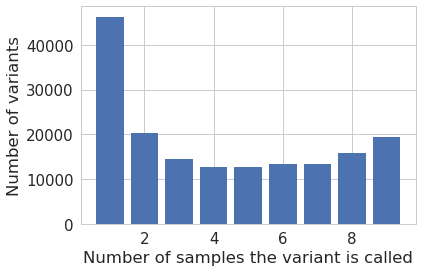

In [101]:
freq_SNPs = freq_SNPs.sort_index()
freq_SNPs = freq_SNPs[freq_SNPs.index < 10]

plt.figure()
plt.bar(freq_SNPs.index, freq_SNPs[0])
plt.xlabel('Number of samples the variant is called')
plt.ylabel('Number of variants')
plt.show()

In [151]:
freq_snps = pd.DataFrame.from_dict(Counter(all_called_sites['SNP']), orient = 'index')

snps_to_use = freq_snps[freq_snps[0] >= 5].index
sites_to_use = all_called_sites.set_index('SNP').loc[snps_to_use]
sites_to_use = sites_to_use.reset_index().drop_duplicates()

sites_by_genotype = sites_to_use.pivot(index = 'SNP', columns = 'Sample')['Genotype']


sites_by_genotype_arr = np.array(sites_by_genotype)
sites_by_genotype_arr[np.isnan(sites_by_genotype_arr)] = -1

In [153]:
unique_numbers = list(map(lambda x: len(set(x)), np.array(sites_by_genotype_arr)))
na_numbers = list(map(lambda x: np.sum(x==-1)>0, np.array(sites_by_genotype_arr)))

In [156]:
Counter(np.array(unique_numbers) - np.array(na_numbers))

Counter({2: 41324, 3: 20916, 1: 12319})

In [136]:
len(set(snps_to_use))

61853